In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap

In [12]:
# 1. Load Data
df = pd.read_csv('chicago_airbnb_cleaned.csv')

# Define your strategic feature list
optimized_features = [
    'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
    'host_is_superhost', 'host_listings_count', 'minimum_nights',
    'instant_bookable', 'availability_365', 'number_of_reviews',
    'reviews_per_month', 'review_scores_rating',
    'room_type_Private room', 'room_type_Shared room', 'room_type_Hotel room',
    'property_type_clean_Entire home', 'property_type_clean_Entire rental unit',
    'Amenity_PCA_1', 'Amenity_PCA_2', 'Amenity_PCA_3', 'Amenity_PCA_4', 'Amenity_PCA_5'
]

# Ensure the selected features are strictly numeric
# This maps any remaining 't'/'f' to 1/0 just in case
X = df[optimized_features].copy()
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].map({'t': 1, 'f': 0, 1: 1, 0: 0}).fillna(0)

# Final numeric check
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

In [13]:
# 2. Feature Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

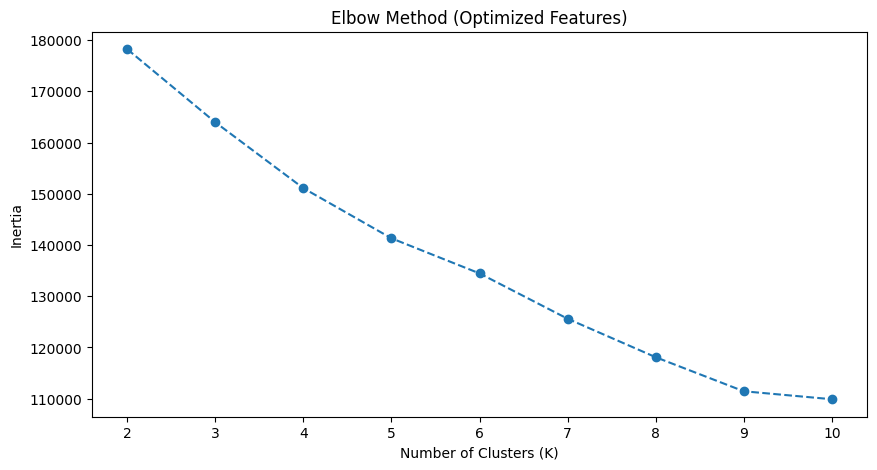

In [14]:
# 3. Elbow Method
inertia = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='#1f77b4')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method (Optimized Features)')
plt.show()

In [15]:
# 4. Final K-Means (Using K=5 as seen in your previous plot)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster_ID'] = kmeans.fit_predict(X_scaled)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


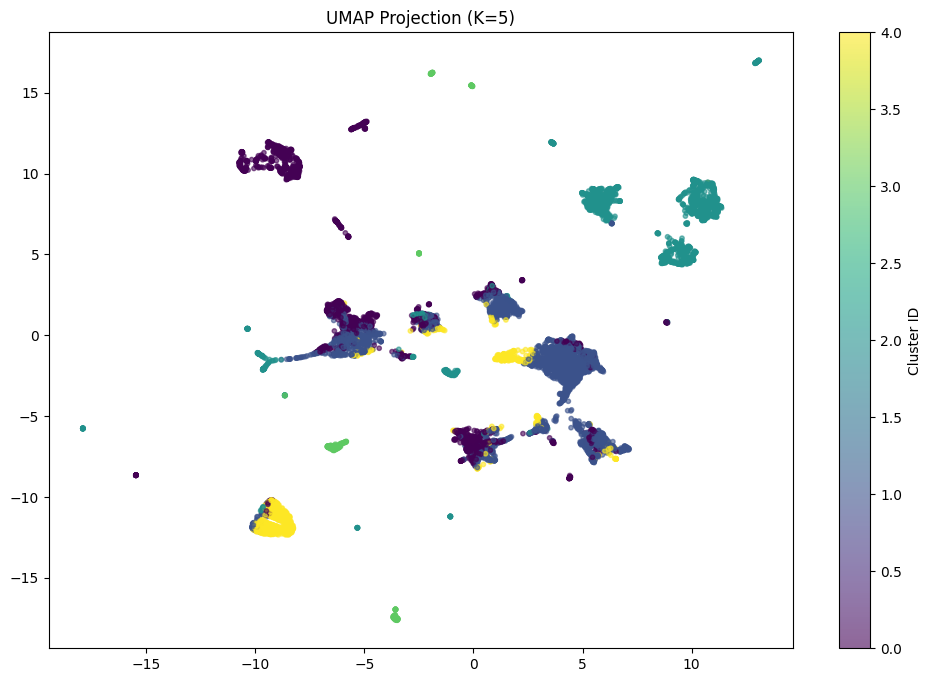

In [16]:
# 5. UMAP for Visualization
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=df['Cluster_ID'], cmap='viridis', s=10, alpha=0.6)
plt.colorbar(label='Cluster ID')
plt.title(f'UMAP Projection (K={optimal_k})')
plt.show()

In [18]:
# Calculate the average values for key business metrics per cluster
cluster_profile = df.groupby('Cluster_ID')[['price', 'accommodates', 'review_scores_rating', 'Amenity_PCA_1', 'Amenity_PCA_2']].mean()

# Sort by price to see the market hierarchy
print(cluster_profile.sort_values(by='price', ascending=False))

                   price  accommodates  review_scores_rating  Amenity_PCA_1  \
Cluster_ID                                                                    
3           11378.912409      3.532847              4.787810      -1.251853   
4             494.539022     10.421436              4.832778       0.983285   
0             193.840654      3.261682              4.719776      -1.111166   
1             191.606408      5.054674              4.844353       0.918405   
2              91.995220      2.010621              4.720685      -0.716116   

            Amenity_PCA_2  
Cluster_ID                 
3                0.114965  
4               -0.139310  
0                0.488286  
1               -0.001177  
2               -0.498433  


In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 1. Calculate Evaluation Metrics
print("--- Clustering Quantitative Evaluation ---")

# Silhouette Score (Closer to 1 is better)
sil_score = silhouette_score(X_scaled, df['Cluster_ID'])
print(f"Silhouette Score: {sil_score:.4f}")

# Davies-Bouldin Index (Lower is better)
dbi_score = davies_bouldin_score(X_scaled, df['Cluster_ID'])
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

# Calinski-Harabasz Index (Higher is better)
ch_score = calinski_harabasz_score(X_scaled, df['Cluster_ID'])
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

--- Clustering Quantitative Evaluation ---
Silhouette Score: 0.1295
Davies-Bouldin Index: 2.0651
Calinski-Harabasz Index: 886.0628


In [20]:
# Grouping by Cluster_ID to see the business DNA of each segment
profile = df.groupby('Cluster_ID')[['price', 'accommodates', 'review_scores_rating', 'Amenity_PCA_1', 'Amenity_PCA_2']].mean()

# Formatting for better readability
print("📊 Cluster Business Profiles (Average Values):")
print(profile.sort_values(by='price', ascending=False).round(2))

📊 Cluster Business Profiles (Average Values):
               price  accommodates  review_scores_rating  Amenity_PCA_1  \
Cluster_ID                                                                
3           11378.91          3.53                  4.79          -1.25   
4             494.54         10.42                  4.83           0.98   
0             193.84          3.26                  4.72          -1.11   
1             191.61          5.05                  4.84           0.92   
2              92.00          2.01                  4.72          -0.72   

            Amenity_PCA_2  
Cluster_ID                 
3                    0.11  
4                   -0.14  
0                    0.49  
1                   -0.00  
2                   -0.50  


In [22]:
df[['id', 'Cluster_ID']].to_csv('airbnb_cluster_labels.csv', index=False)
df.to_csv('chicago_airbnb_master_features.csv', index=False)